In [60]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, SimpleRNN, LSTM, GRU, Dense,
    TimeDistributed, RepeatVector, Bidirectional,
    Activation, Lambda
)
import matplotlib.pyplot as plt


In [61]:
# Data generation
def generate_data(n_samples, sequence_length, vocab_size):
    X = np.random.randint(1, vocab_size, size=(n_samples, sequence_length))
    Y = np.flip(X, axis=1)
    return X, Y


In [62]:
# Parameters
n_samples = 10000
sequence_length = 10
vocab_size = 20

In [63]:
# Prepare one-hot data
X_raw, Y_raw = generate_data(n_samples, sequence_length, vocab_size)
X_oh = tf.keras.utils.to_categorical(X_raw, num_classes=vocab_size)
Y_oh = tf.keras.utils.to_categorical(Y_raw, num_classes=vocab_size)

In [64]:
# Attention mechanism
def attention_layer(hidden_states):
    score = Dense(1, activation='tanh')(hidden_states)
    weights = Activation('softmax', name='attention_weights')(score)
    context = Lambda(lambda x: tf.reduce_sum(x[0] * x[1], axis=1))([weights, hidden_states])
    return context

In [65]:
# Build model
def build_model(cell_type="LSTM"):
    inputs = Input(shape=(sequence_length, vocab_size))

    if cell_type == "LSTM":
        encoder = Bidirectional(LSTM(128, return_sequences=True))(inputs)
    elif cell_type == "GRU":
        encoder = Bidirectional(GRU(128, return_sequences=True))(inputs)
    else:
        encoder = Bidirectional(SimpleRNN(128, return_sequences=True))(inputs)

    context = attention_layer(encoder)
    decoder = RepeatVector(sequence_length)(context)

    if cell_type == "LSTM":
        decoder = LSTM(128, return_sequences=True)(decoder)
    elif cell_type == "GRU":
        decoder = GRU(128, return_sequences=True)(decoder)
    else:
        decoder = SimpleRNN(128, return_sequences=True)(decoder)

    outputs = TimeDistributed(Dense(vocab_size, activation='softmax'))(decoder)
    model = Model(inputs, outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
    return model

In [66]:
# Train all models
models, histories = {}, {}
for cell in ["SimpleRNN", "LSTM", "GRU"]:
    print(f"\nTraining {cell} with attention (one-hot input)...")
    model = build_model(cell)
    history = model.fit(
        X_oh, Y_oh,
        epochs=30,
        batch_size=128,
        validation_split=0.2,
        verbose=1,
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
    )
    models[cell] = model
    histories[cell] = history
    print(f"{cell} training done.")


Training SimpleRNN with attention (one-hot input)...
Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 138ms/step - categorical_accuracy: 0.1796 - loss: 2.5805 - val_categorical_accuracy: 0.2309 - val_loss: 2.2424
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - categorical_accuracy: 0.2401 - loss: 2.1958 - val_categorical_accuracy: 0.2709 - val_loss: 2.0807
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - categorical_accuracy: 0.2963 - loss: 2.0098 - val_categorical_accuracy: 0.3629 - val_loss: 1.8375
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - categorical_accuracy: 0.4019 - loss: 1.7449 - val_categorical_accuracy: 0.4818 - val_loss: 1.5326
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - categorical_accuracy: 0.5224 - loss: 1.4327 - val_categorical_accuracy: 0.6026 - val_loss: 1.2188
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.6437 - loss: 1.1139 - val_categorical_accuracy: 0.7194 - val_loss: 0.9114
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6m

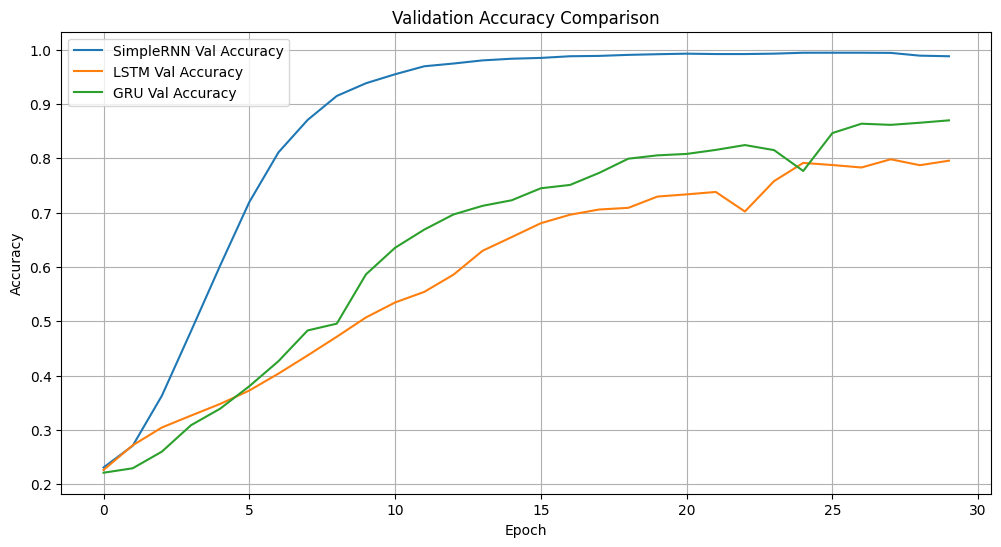

In [67]:
# Validation Accuracy Plot
plt.figure(figsize=(12, 6))
for cell in histories:
    plt.plot(histories[cell].history['val_categorical_accuracy'], label=f"{cell} Val Accuracy")
plt.title("Validation Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [68]:
# Evaluate on one test sample
X_eval, Y_eval = generate_data(1, sequence_length, vocab_size)
X_eval_oh = tf.keras.utils.to_categorical(X_eval, num_classes=vocab_size)
Y_eval_oh = tf.keras.utils.to_categorical(Y_eval, num_classes=vocab_size)

In [69]:
# Decode prediction
def decode(pred):
    return [np.argmax(vec) for vec in pred]

print("\n--- Predictions ---")
print("Input:    ", X_eval[0])
print("Expected: ", Y_eval[0])
for cell in models:
    pred = models[cell].predict(X_eval_oh, verbose=0)[0]
    print(f"{cell} Predicted:", np.array(decode(pred)))


--- Predictions ---
Input:     [ 3  6 12  6 15  1 17 13  7  1]
Expected:  [ 1  7 13 17  1 15  6 12  6  3]
SimpleRNN Predicted: [ 1  7 13 17  1 15  6 12  6  3]
LSTM Predicted: [ 1  7 13 17  1 15 12  6  3  3]
GRU Predicted: [ 1  7 13 17  1 15 12 12  6  3]


In [70]:
# Evaluate Accuracy
for cell in models:
    acc = models[cell].evaluate(X_eval_oh, Y_eval_oh, verbose=0)[1]
    print(f"{cell} Accuracy: {acc:.4f}")

SimpleRNN Accuracy: 1.0000
LSTM Accuracy: 0.7000
GRU Accuracy: 0.9000


In [71]:
# Plot individual training histories
def plot_history(hist, name):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(hist.history['categorical_accuracy'], label='Train')
    plt.plot(hist.history['val_categorical_accuracy'], label='Val')
    plt.title(f'{name} Accuracy')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(hist.history['loss'], label='Train')
    plt.plot(hist.history['val_loss'], label='Val')
    plt.title(f'{name} Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

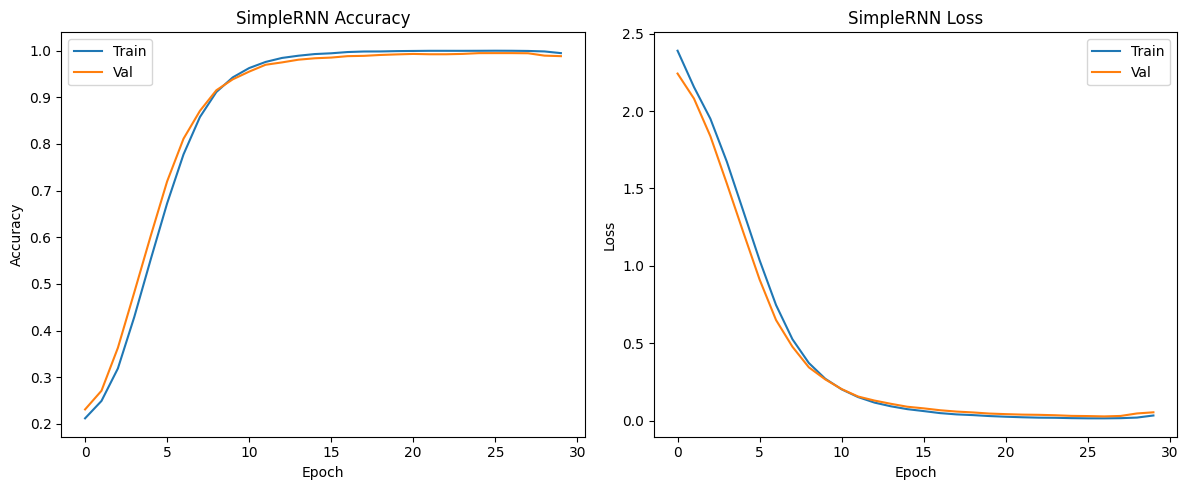

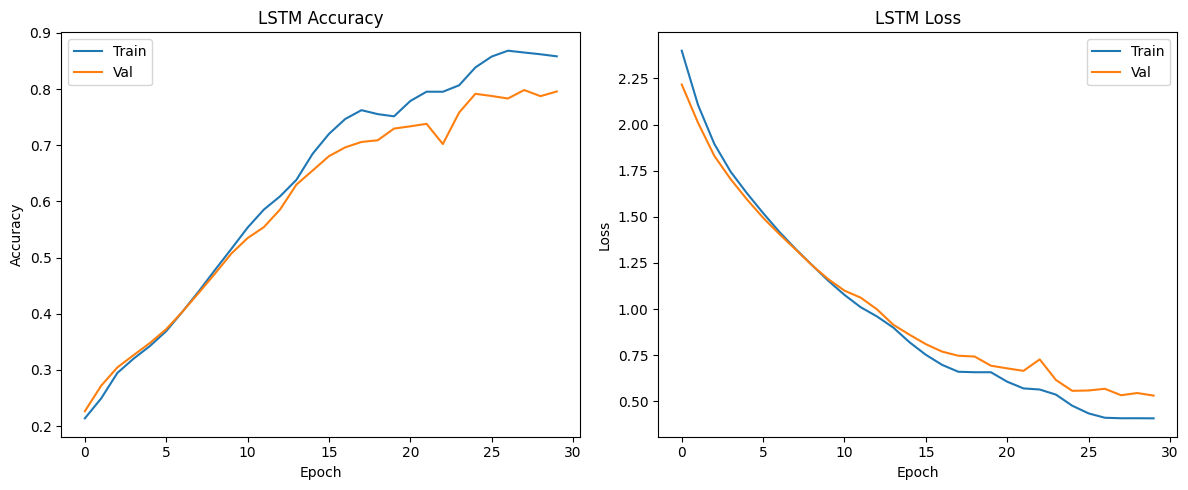

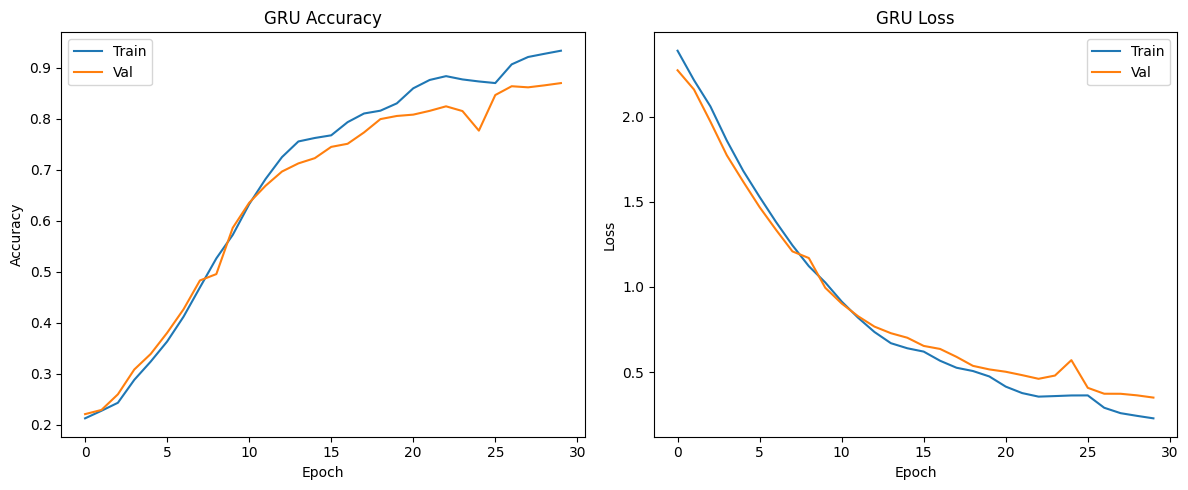

In [72]:
for cell in models:
    plot_history(histories[cell], cell)